In [2]:
# Importing neccessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil.relativedelta import relativedelta
import missingno as msno
from scipy.stats import zscore
from fancyimpute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
from imblearn import over_sampling, under_sampling, combine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, make_scorer, cohen_kappa_score
from xgboost import XGBClassifier
%matplotlib inline

In [168]:
# Reading data from csv and converting as dataframe
# Taking intial look at the data

bank_df = pd.read_csv('train.csv', parse_dates=['DOB', 'Lead_Creation_Date'])
bank_df.head()

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,1979-07-23,2016-07-15,C10001,A,COM0044082,A,4.0,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
1,APPD40611263344,Male,1986-07-12,2016-04-07,C10003,A,COM0000002,C,1.0,3500.0,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
2,APPE70289249423,Male,1982-10-12,2016-07-19,C10125,C,COM0005267,C,4.0,2250.0,...,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0
3,APPF80273865537,Male,1989-01-30,2016-09-07,C10477,C,COM0004143,A,4.0,3500.0,...,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0
4,APPG60994436641,Male,1985-04-19,2016-07-20,C10002,A,COM0001781,A,4.0,10000.0,...,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0


In [169]:
# Dropping ID feature because it doesn't contribute any value to our analysis

bank_df.drop(['ID'], axis=1, inplace=True)

In [170]:
# Getting the info about datatype of features and checking for any null values present in the feature 

bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69713 entries, 0 to 69712
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Gender                               69713 non-null  object        
 1   DOB                                  69698 non-null  datetime64[ns]
 2   Lead_Creation_Date                   69713 non-null  datetime64[ns]
 3   City_Code                            68899 non-null  object        
 4   City_Category                        68899 non-null  object        
 5   Employer_Code                        65695 non-null  object        
 6   Employer_Category1                   65695 non-null  object        
 7   Employer_Category2                   65415 non-null  float64       
 8   Monthly_Income                       69713 non-null  float64       
 9   Customer_Existing_Primary_Bank_Code  60322 non-null  object        
 10  Primary_Ba

In [171]:
# converting Approved and Employer_Category2 feature to their appropriate datatypes

bank_df['Approved'] = bank_df['Approved'].astype(object)
bank_df['Employer_Category2'] = bank_df['Employer_Category2'].astype(object)

In [172]:
mask = bank_df[(bank_df.DOB.dt.year >= 2016)].index
bank_df.loc[mask,'DOB'] = np.NaN

In [173]:
# Creating Age at the time of lead creation from the DOB

bank_df['Age'] = round((bank_df.Lead_Creation_Date - bank_df.DOB) / np.timedelta64(1, 'Y'), 0)

In [174]:
# Dropping DOB, as age is calculated from that

bank_df.drop(['DOB'], axis=1, inplace=True)

In [175]:
# Getting summary of numerical features to check for any abnormalities

bank_df.describe()

,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Age
count,6.971300e+04,69662.000000,42004.000000,42004.000000,22276.000000,22276.000000,69713.000000,66665.000000
mean,5.622283e+03,360.928751,39429.982859,3.890629,19.213570,1101.466242,3.948446,29.844251
std,1.747671e+05,2288.517927,30727.595990,1.167491,5.847136,752.661394,3.819214,5.472729
min,0.000000e+00,0.000000,5000.000000,1.000000,11.990000,118.000000,0.000000,17.000000
25%,1.650000e+03,0.000000,20000.000000,3.000000,15.250000,649.000000,0.000000,26.000000
50%,2.500000e+03,0.000000,30000.000000,4.000000,18.000000,941.000000,2.000000,29.000000
75%,4.000000e+03,350.000000,50000.000000,5.000000,20.000000,1295.000000,7.000000,33.000000
max,3.838384e+07,545436.500000,300000.000000,6.000000,37.000000,13556.000000,10.000000,47.000000


**Key Inferences**

1. Observations with monthly income of 0 is available, which can be missing value or person with no montly income. 
2. Max monthly income need to be investigated.
3. Max EMI need to be investigated.

In [176]:
# Getting summary for categorical features

bank_df.describe(include=object)

,Gender,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Approved
count,69713,68899,68899,65695,65695,65415.0,60322,60322,69713,69713,69713,69713
unique,2,678,3,36617,3,4.0,57,2,2,29,7,2
top,Male,C10001,A,COM0000002,A,4.0,B001,P,Y,S122,B,0
freq,39949,10007,49885,457,33336,57582.0,14197,39619,45275,30941,29812,68693


**Inferences**
1. City Code, Employer_code, Customer_Existing_Primary_Bank_Code, Source are having high cardinality.
2. In Approved (Target Variable) frequency of '0' high indicating class labels are imbalanced.

In [177]:
# Getting count of class labels in target variable

bank_df.Approved.value_counts()

0    68693
1     1020
Name: Approved, dtype: int64

In [178]:
# Transforming high cardinality columns using weight of evidence technique

def reduce_cardinality(colName):
    code_dict = {}
    total_positives = bank_df.Approved.value_counts()[1]
    total_negatives = bank_df.Approved.value_counts()[0]

    for val in bank_df[colName].unique():
        try:
            positive_ratio = bank_df[bank_df.City_Code==val].Approved.value_counts()[1]/total_positives
        except:
            positive_ratio = 1e-15
        
        try:
            negative_ratio = bank_df[bank_df.City_Code==val].Approved.value_counts()[0]/total_negatives
        except:
            negative_ratio = 1e-15
        
        code_dict[val] = np.log(positive_ratio/negative_ratio)
    return code_dict

In [179]:
City_Code_dict = reduce_cardinality(colName='City_Code')
Employer_Code_dict = reduce_cardinality(colName='Employer_Code')
Customer_Existing_Primary_Bank_Code_dict = reduce_cardinality(colName='Customer_Existing_Primary_Bank_Code')
Source_dict = reduce_cardinality(colName='Source')

In [180]:
bank_df.City_Code = bank_df.City_Code.apply(lambda x: round(City_Code_dict[x],2))
bank_df.Employer_Code = bank_df.Employer_Code.apply(lambda x: round(Employer_Code_dict[x],2))
bank_df.Customer_Existing_Primary_Bank_Code = bank_df.Customer_Existing_Primary_Bank_Code.apply(lambda x: 
                                                                                                round(Customer_Existing_Primary_Bank_Code_dict[x],2))
bank_df.Source = bank_df.Source.apply(lambda x: round(Source_dict[x],2))

In [74]:
'''def get_frequency_encoding(colName):
    return bank_df[colName].value_counts().to_dict()'''

In [75]:
'''City_Code_freq = get_frequency_encoding(colName='City_Code')
Employer_Code_freq = get_frequency_encoding(colName='Employer_Code')
Customer_Existing_Primary_Bank_Code_freq = get_frequency_encoding(colName='Customer_Existing_Primary_Bank_Code')
Source_freq = get_frequency_encoding(colName='Source')'''

In [77]:
'''bank_df.City_Code = bank_df.City_Code.apply(lambda x: np.nan if type(x) == float else City_Code_freq[x])
bank_df.Employer_Code = bank_df.Employer_Code.apply(lambda x: np.nan if type(x) == float else Employer_Code_freq[x])
bank_df.Customer_Existing_Primary_Bank_Code = bank_df.Customer_Existing_Primary_Bank_Code.apply(lambda x: np.nan if type(x) == float 
                                                                                                else Customer_Existing_Primary_Bank_Code_freq[x])
bank_df.Source = bank_df.Source.apply(lambda x: np.nan if type(x) == float else Source_freq[x])'''

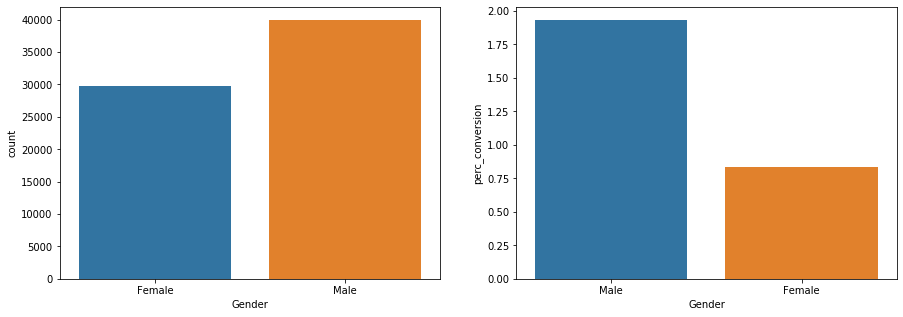

In [181]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(bank_df.Gender, ax=ax[0])
approved_df = bank_df[bank_df.Approved==1]
male_conv_perc = (approved_df[approved_df.Gender=='Male'].shape[0] / bank_df[bank_df.Gender=='Male'].shape[0])*100
female_conv_perc = (approved_df[approved_df.Gender=='Female'].shape[0] / bank_df[bank_df.Gender=='Female'].shape[0])*100
gender_conv_df = pd.DataFrame({'Gender':['Male', 'Female'], 'perc_conversion':[male_conv_perc, female_conv_perc]})
sns.barplot(gender_conv_df.Gender, gender_conv_df.perc_conversion, ax=ax[1])

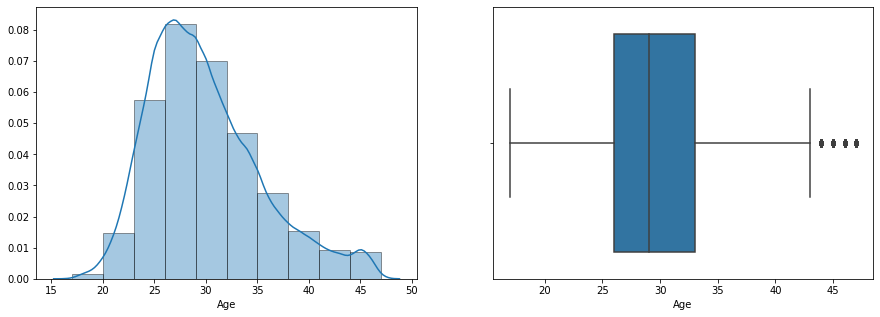

In [182]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(bank_df.Age, bins=10, hist_kws={'edgecolor':'black'}, ax=ax[0])
sns.boxplot(bank_df.Age)

In [183]:
def get_outlier_index(colName, normalize=False):
    if normalize:
        df = pd.DataFrame(StandardScaler().fit_transform(np.array(np.log(bank_df[colName])).reshape(-1,1)), 
                          index=bank_df.index)
    else:
        df = pd.DataFrame(StandardScaler().fit_transform(np.array(bank_df.Age).reshape(-1,1)), index=bank_df.index)
    df.rename(columns={0:colName}, inplace=True)
    outliers_index = []
    for index, val in df.iterrows():
        if np.isnan(val[colName]): continue
        elif (val[colName] < -3) or (val[colName] > 3):
            outliers_index.append(index)
    return outliers_index

In [184]:
age_outliers = get_outlier_index(colName='Age')

In [185]:
bank_df = bank_df[~(bank_df.index.isin(age_outliers))]

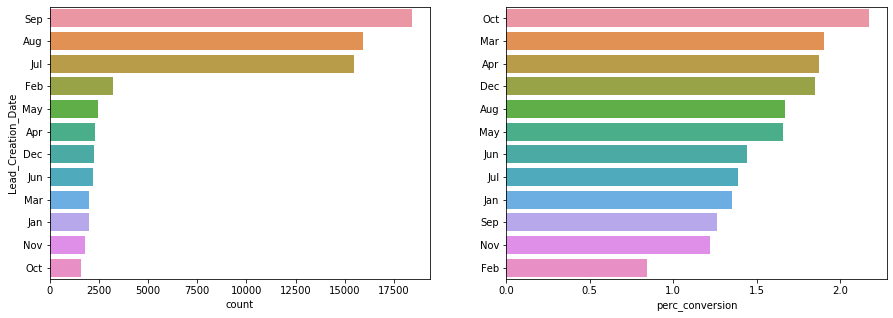

In [186]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(y=bank_df.Lead_Creation_Date.dt.strftime('%b'), 
              order=bank_df.Lead_Creation_Date.dt.strftime('%b').value_counts().index, ax=ax[0])
month_df = pd.DataFrame(bank_df.Lead_Creation_Date.dt.strftime('%b').value_counts())
month_app_df = pd.DataFrame(bank_df[bank_df.Approved==1].Lead_Creation_Date.dt.strftime('%b').value_counts())
month_conv_df = pd.merge(month_df, month_app_df, left_index=True, right_index=True)
month_conv_df['perc_conversion'] = round((month_conv_df.Lead_Creation_Date_y / month_conv_df.Lead_Creation_Date_x)*100,2)
month_conv_df = month_conv_df.sort_values('perc_conversion', ascending=False)
sns.barplot(y=month_conv_df.index, x=month_conv_df.perc_conversion, ax=ax[1])

In [187]:
def get_perc_conv_for_cat_features(col):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    sns.countplot(bank_df[col], ax=ax[0])
    actual_df = pd.DataFrame(bank_df[col].value_counts())
    approved_df = pd.DataFrame(bank_df[bank_df.Approved==1][col].value_counts())
    conv_df = pd.merge(actual_df, approved_df, left_index=True, right_index=True)
    conv_df['perc_conversion'] = round((conv_df[col+'_y'] / conv_df[col+'_x'])*100,2)
    conv_df = conv_df.sort_values('perc_conversion', ascending=False)
    sns.barplot(x=conv_df.index, y=conv_df.perc_conversion, ax=ax[1])

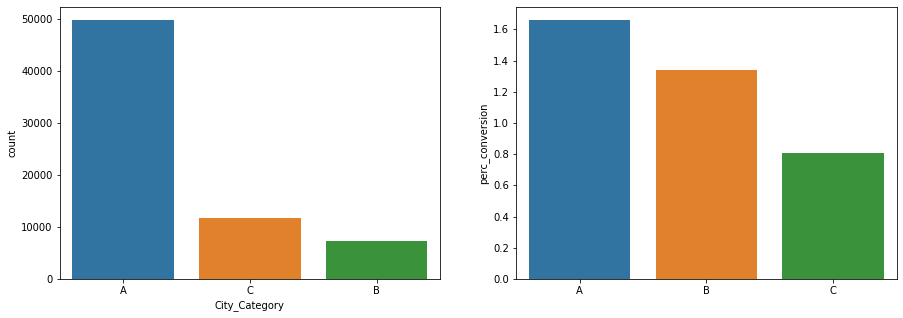

In [188]:
get_perc_conv_for_cat_features('City_Category')

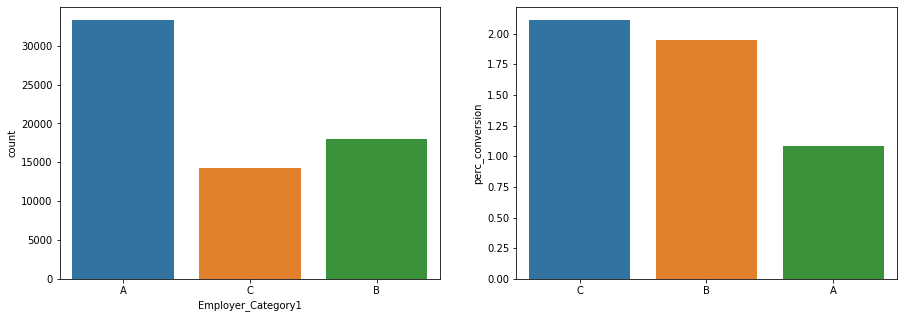

In [189]:
get_perc_conv_for_cat_features('Employer_Category1')

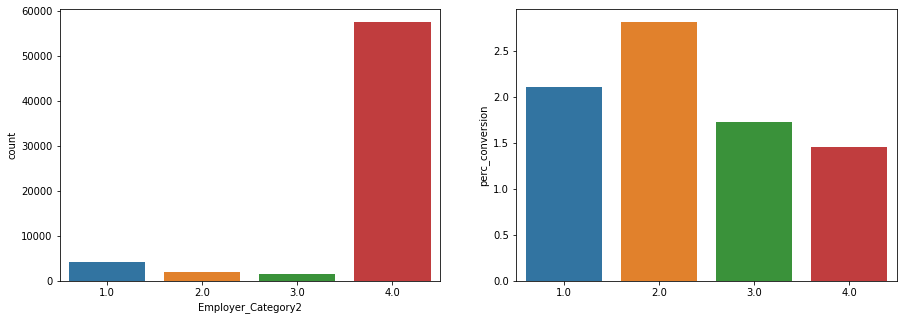

In [190]:
get_perc_conv_for_cat_features('Employer_Category2')

In [191]:
bank_df = bank_df[~(bank_df.Monthly_Income==0)]

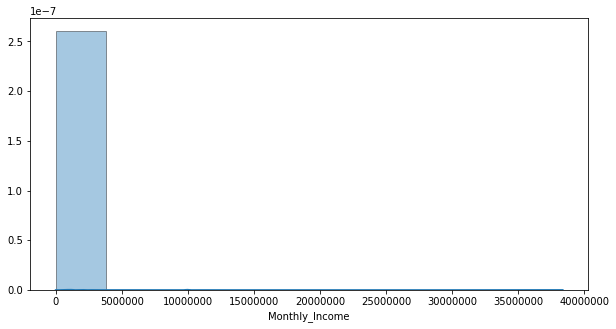

In [192]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.distplot(bank_df.Monthly_Income, bins=10, hist_kws={'edgecolor':'black'})
plt.ticklabel_format(style='plain', axis='x')

In [193]:
income_outliers = get_outlier_index(colName='Monthly_Income', normalize=True)

In [194]:
bank_df = bank_df[~(bank_df.index.isin(income_outliers))]

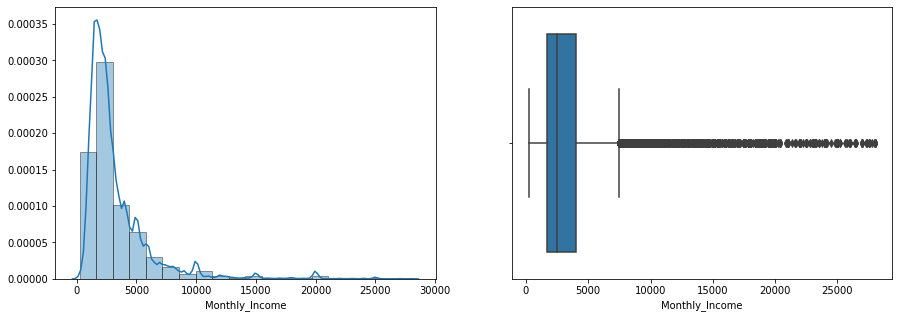

In [195]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.distplot(bank_df.Monthly_Income, bins=20, hist_kws={'edgecolor':'black'}, ax=ax[0])
sns.boxplot(bank_df.Monthly_Income, ax=ax[1])

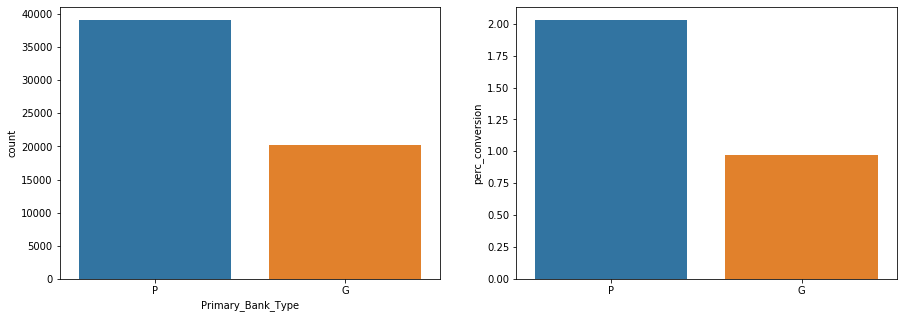

In [196]:
get_perc_conv_for_cat_features('Primary_Bank_Type')

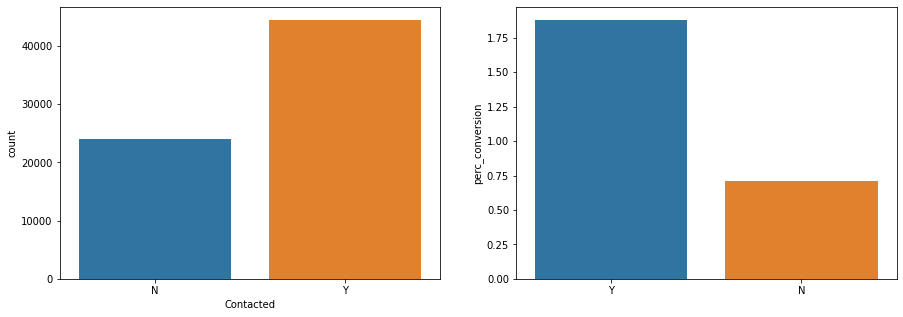

In [197]:
get_perc_conv_for_cat_features('Contacted')

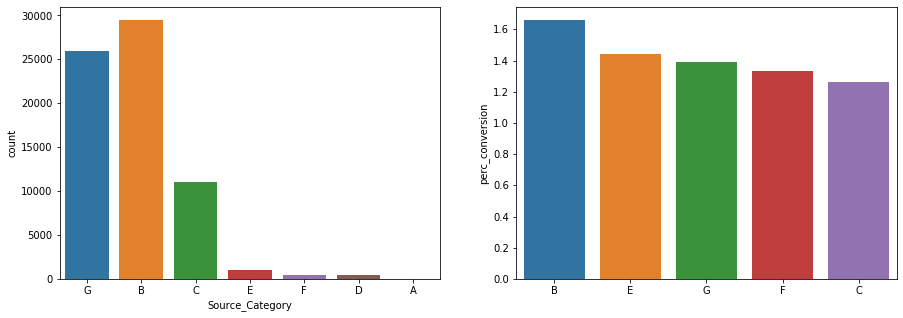

In [198]:
get_perc_conv_for_cat_features('Source_Category')

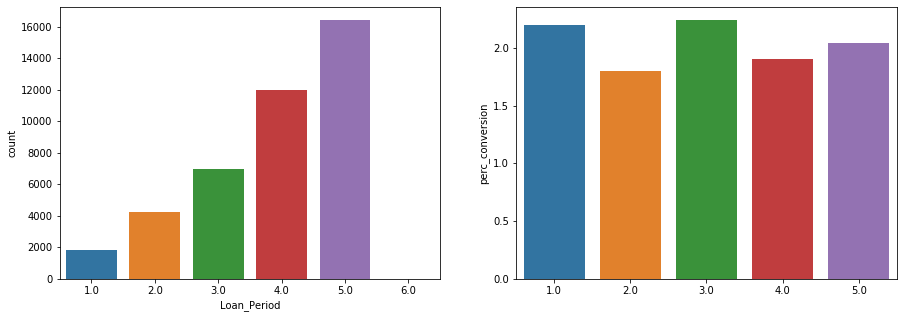

In [199]:
get_perc_conv_for_cat_features('Loan_Period')

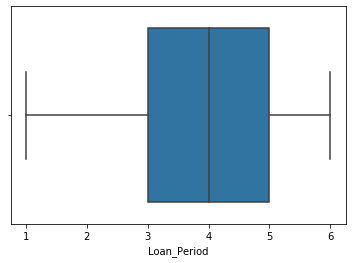

In [200]:
sns.boxplot(bank_df.Loan_Period)

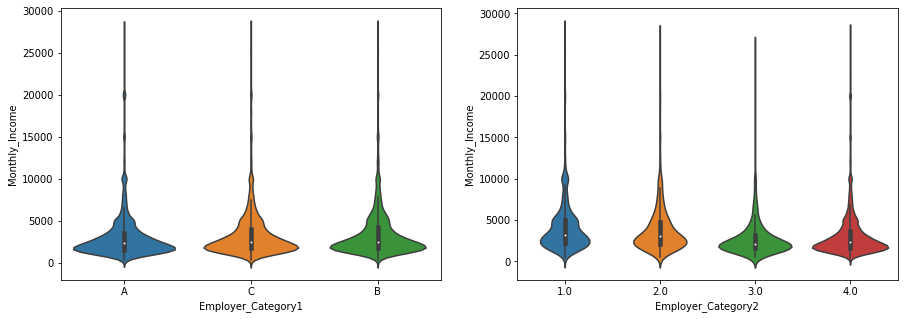

In [201]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.violinplot(bank_df.Employer_Category1, bank_df.Monthly_Income, ax=ax[0])
sns.violinplot(bank_df.Employer_Category2, bank_df.Monthly_Income, ax=ax[1])

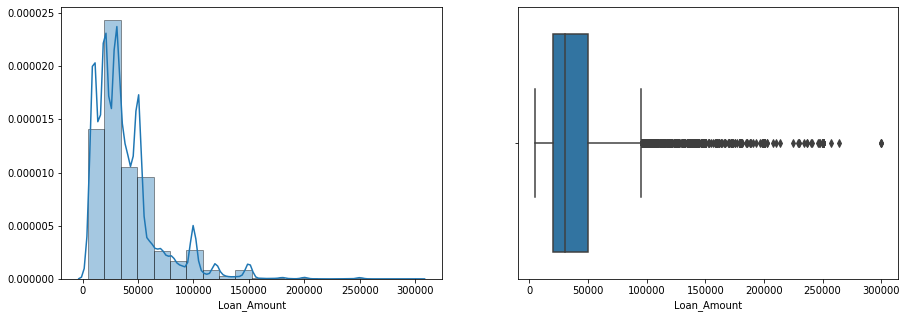

In [202]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.distplot(bank_df.Loan_Amount, bins=20, hist_kws={'edgecolor':'black'}, ax=ax[0])
sns.boxplot(bank_df.Loan_Amount, ax=ax[1])

In [203]:
loan_amt_outliers = get_outlier_index(colName='Loan_Amount', normalize=True)

In [204]:
bank_df = bank_df[~(bank_df.index.isin(loan_amt_outliers))]

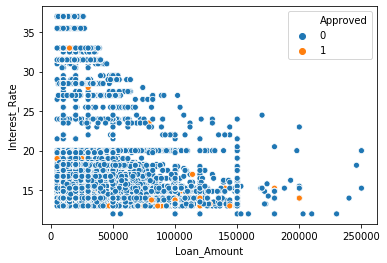

In [205]:
sns.scatterplot(bank_df.Loan_Amount, bank_df.Interest_Rate, hue=bank_df.Approved)

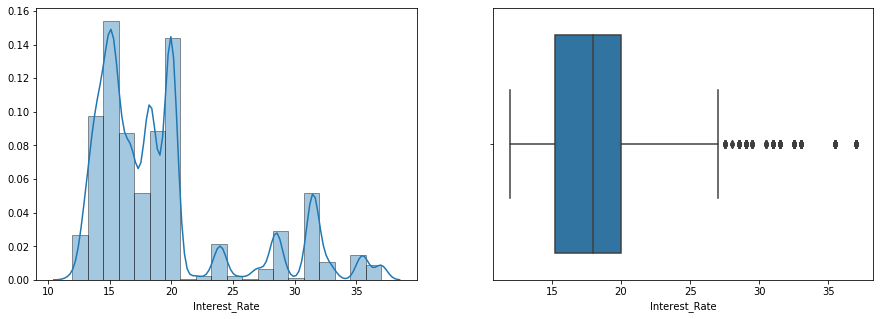

In [206]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.distplot(bank_df.Interest_Rate, bins=20, hist_kws={'edgecolor':'black'}, ax=ax[0])
sns.boxplot(bank_df.Interest_Rate, ax=ax[1])

In [207]:
interest_rate_outliers = get_outlier_index(colName='Interest_Rate', normalize=True)

In [208]:
bank_df.Monthly_Income = bank_df.Monthly_Income - bank_df.Existing_EMI

In [209]:
bank_df.drop(['Existing_EMI'], axis=1, inplace=True)

In [210]:
bank_df = bank_df[~(bank_df.EMI>=bank_df.Monthly_Income)]

In [211]:
def missing_val_perc(df):
    for col in df.columns:
        print("Percentage of missing values in " + col + ": " + str(round(bank_df[col].isna().sum()/bank_df.shape[0],2)))

In [212]:
missing_val_perc(df=bank_df)

Percentage of missing values in Gender: 0.0
Percentage of missing values in Lead_Creation_Date: 0.0
Percentage of missing values in City_Code: 0.0
Percentage of missing values in City_Category: 0.01
Percentage of missing values in Employer_Code: 0.0
Percentage of missing values in Employer_Category1: 0.05
Percentage of missing values in Employer_Category2: 0.06
Percentage of missing values in Monthly_Income: 0.0
Percentage of missing values in Customer_Existing_Primary_Bank_Code: 0.0
Percentage of missing values in Primary_Bank_Type: 0.13
Percentage of missing values in Contacted: 0.0
Percentage of missing values in Source: 0.0
Percentage of missing values in Source_Category: 0.0
Percentage of missing values in Loan_Amount: 0.39
Percentage of missing values in Loan_Period: 0.39
Percentage of missing values in Interest_Rate: 0.68
Percentage of missing values in EMI: 0.68
Percentage of missing values in Var1: 0.0
Percentage of missing values in Approved: 0.0
Percentage of missing values 

In [213]:
index_nums = [index for index, val in enumerate(bank_df.isna().sum(axis=1)) if val>7]
bank_df.drop(bank_df.index[index_nums], inplace=True)

In [214]:
for col in ['City_Category', 'Employer_Category1', 'Employer_Category2', 'Primary_Bank_Type']:
    bank_df[col].fillna(bank_df[col].mode()[0], inplace=True)

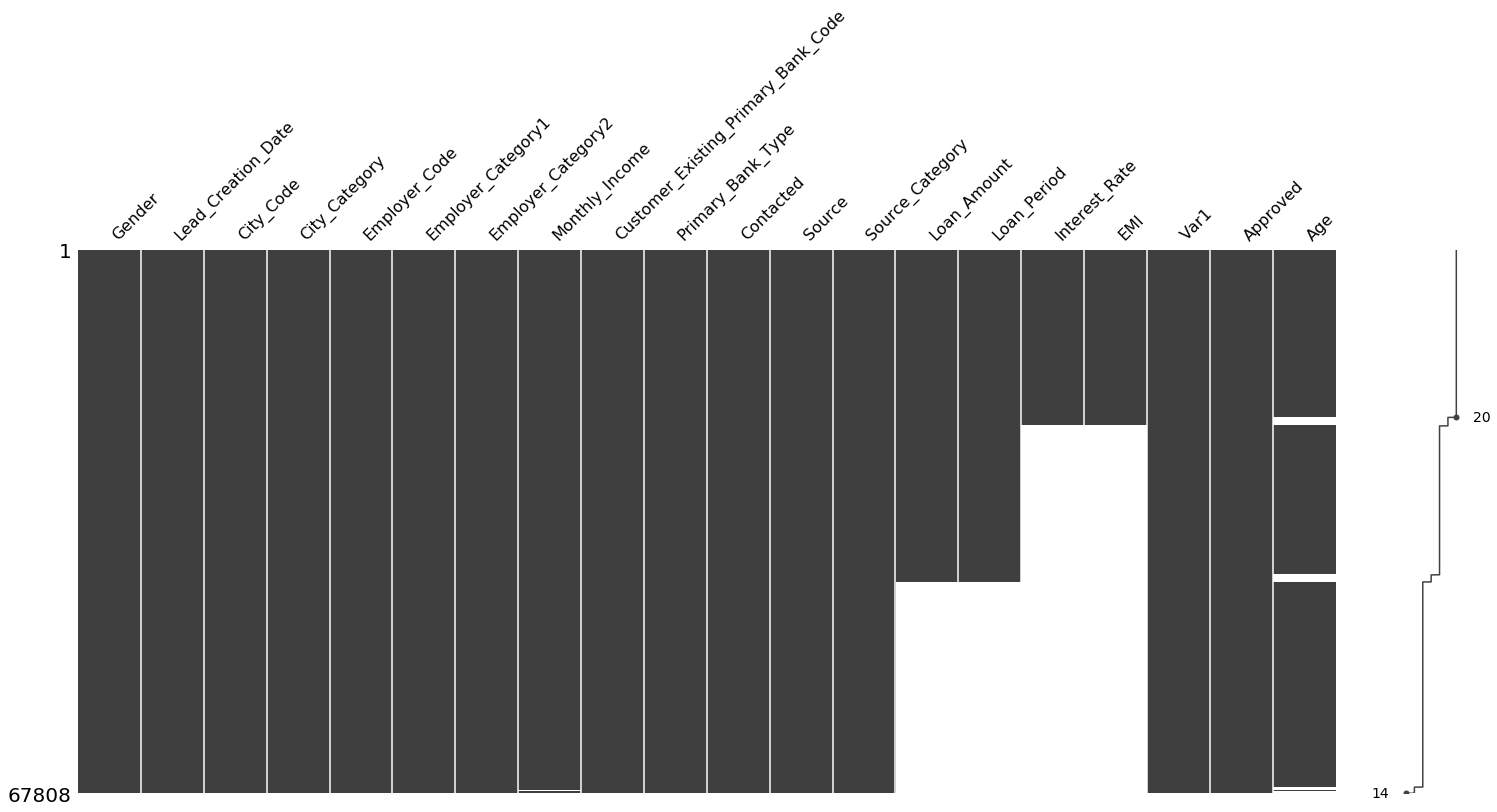

In [215]:
msno.matrix(bank_df, sort='descending')

In [216]:
mask = bank_df[(~((bank_df.Loan_Amount.isna())&(bank_df.Loan_Period.isna())))&(bank_df.Interest_Rate.isna())].index
bank_df.loc[mask, 'Interest_Rate'] = bank_df.Interest_Rate.median()

In [217]:
def emi_calculator(principal, interest, period): 
    interest = interest / (12*100) 
    period = period * 12
    EMI = (principal * interest * pow(1+interest, period)) / (pow(1+interest, period)-1) 
    return round(EMI,0)

In [218]:
mask = bank_df[(~((bank_df.Loan_Amount.isna())&(bank_df.Loan_Period.isna())&(bank_df.Interest_Rate.isna())))
               &(bank_df.EMI.isna())].index
bank_df.loc[mask, 'EMI'] = emi_calculator(bank_df.Loan_Amount, bank_df.Interest_Rate, bank_df.Loan_Period)

In [219]:
bank_df = bank_df[~((bank_df.Monthly_Income.isna())|(bank_df.Monthly_Income==0))]

In [220]:
bank_df[['Employer_Category1','City_Category','Source_Category']] = bank_df[['Employer_Category1','City_Category',
                                                                             'Source_Category']].apply(LabelEncoder().fit_transform)

In [221]:
bank_df.Gender = bank_df.Gender.map({'Male':0,'Female':1})

In [222]:
bank_df.Primary_Bank_Type = bank_df.Primary_Bank_Type.map({'P':0,'G':1})
bank_df.Contacted = bank_df.Contacted.map({'N':0, 'Y':1})

In [223]:
bank_df['Lead_Creation_Day'] = bank_df.Lead_Creation_Date.dt.day
bank_df['Lead_Creation_Month'] = bank_df.Lead_Creation_Date.dt.month
bank_df['Lead_Creation_Day_of_Week'] = bank_df.Lead_Creation_Date.dt.dayofweek
bank_df.drop(['Lead_Creation_Date'], axis=1, inplace=True)

In [228]:
EMI_backup = bank_df.EMI

In [229]:
bank_df_impute = bank_df.drop(['EMI'], axis=1)
impute_cols = bank_df_impute.columns

In [230]:
iterative_imputer = IterativeImputer(imputation_order='arabic', initial_strategy='median', max_iter=21)
bank_df_impute = iterative_imputer.fit_transform(bank_df_impute)

In [231]:
bank_df_impute = pd.DataFrame(bank_df_impute, columns=impute_cols)

In [232]:
bank_df_impute = bank_df_impute.join(EMI_backup)

In [233]:
bank_df_impute.Interest_Rate = bank_df_impute.Interest_Rate.apply(lambda x: round(x,0))

In [234]:
mask = bank_df_impute[bank_df_impute.EMI.isna()].index
bank_df_impute.loc[mask, 'EMI'] = emi_calculator(bank_df_impute.Loan_Amount, bank_df_impute.Interest_Rate, 
                                                 bank_df_impute.Loan_Period)

In [235]:
bank_df_impute = bank_df_impute[~(bank_df_impute.EMI>=bank_df_impute.Monthly_Income)]

In [236]:
def kappa_score(y_act, y_pred):
    return cohen_kappa_score(y_act, y_pred)

kappa = make_scorer(kappa_score)

# Naive Bayes Classifier

In [237]:
cat_cols = ['Gender', 'City_Category', 'Primary_Bank_Type', 'Contacted', 'Source_Category', 'Var1', 'Employer_Category1',
            'Employer_Category2']

In [238]:
num_cols = ['Monthly_Income','Loan_Amount','City_Code','Loan_Period','Interest_Rate','Age','Lead_Creation_Day','Source',
            'Lead_Creation_Month', 'Lead_Creation_Day_of_Week','EMI','Customer_Existing_Primary_Bank_Code','Employer_Code']

In [239]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=204)

In [240]:
navie_df = bank_df_impute.copy(deep=True)

In [241]:
for col in cat_cols:
    navie_df[col] = navie_df[col].astype('category')

In [242]:
y_naive = navie_df['Approved']
X_naive = navie_df.drop(['Approved'], axis=1)

In [243]:
X_train_naive, X_test_naive, y_train_naive, y_test_naive = train_test_split(X_naive, y_naive, test_size=0.3)

In [244]:
naive_model = GaussianNB()

In [245]:
np.mean(cross_val_score(naive_model, X_train_naive, y_train_naive, scoring='roc_auc', cv=kfold, n_jobs=-1))

0.7674108612679327

In [246]:
naive_model.fit(X_train_naive, y_train_naive)

GaussianNB()

In [247]:
naive_predictions = naive_model.predict(X_test_naive)

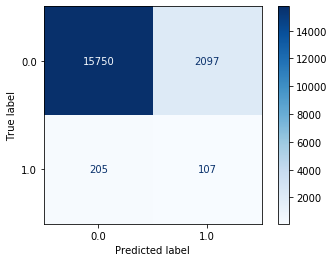

In [248]:
plot_confusion_matrix(naive_model, X_test_naive, y_test_naive, cmap=plt.cm.Blues)

In [249]:
print(classification_report(y_test_naive, naive_predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93     17847
         1.0       0.05      0.34      0.09       312

    accuracy                           0.87     18159
   macro avg       0.52      0.61      0.51     18159
weighted avg       0.97      0.87      0.92     18159



# Logistic Regression

In [250]:
logit_df = bank_df_impute.copy(deep=True)

In [251]:
logit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60530 entries, 0 to 67754
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Gender                               60530 non-null  float64
 1   City_Code                            60530 non-null  float64
 2   City_Category                        60530 non-null  float64
 3   Employer_Code                        60530 non-null  float64
 4   Employer_Category1                   60530 non-null  float64
 5   Employer_Category2                   60530 non-null  float64
 6   Monthly_Income                       60530 non-null  float64
 7   Customer_Existing_Primary_Bank_Code  60530 non-null  float64
 8   Primary_Bank_Type                    60530 non-null  float64
 9   Contacted                            60530 non-null  float64
 10  Source                               60530 non-null  float64
 11  Source_Category             

In [252]:
y_logit = logit_df['Approved']
X_logit = logit_df.drop(['Approved'], axis=1)

In [253]:
for col in cat_cols:
    X_logit[col] = X_logit[col].astype('category')

In [254]:
dummies = pd.get_dummies(X_logit[cat_cols])

In [255]:
col_names = num_cols
scaled_data = StandardScaler().fit_transform(X_logit[num_cols])
num_scaled_data = pd.DataFrame(scaled_data, columns=col_names, index=dummies.index)

In [256]:
X_std_logit = pd.concat([num_scaled_data, dummies], axis=1)

In [257]:
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X_std_logit, y_logit, test_size=0.3)

In [321]:
logit_model = LogisticRegression(class_weight='balanced', random_state=204)
best_logit = GridSearchCV(logit_model, param_grid={'max_iter':[1000,2000,3000], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
                          scoring=kappa, cv=kfold, n_jobs=-1)

In [322]:
best_logit.fit(X_train_logit, y_train_logit)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=204),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [1000, 2000, 3000]},
             scoring=make_scorer(kappa_score))

In [323]:
best_logit.best_params_

{'C': 10, 'max_iter': 1000}

In [258]:
np.mean(cross_val_score(best_logit.best_estimator_, X_train_logit, y_train_logit, scoring='roc_auc', cv=kfold, n_jobs=-1))

0.8056811618417136

In [259]:
final_logit = LogisticRegression(class_weight='balanced', C=10, max_iter=1000, random_state=204)

In [260]:
final_logit.fit(X_train_logit, y_train_logit)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=204)

In [261]:
logit_predictions = final_logit.predict(X_test_logit)

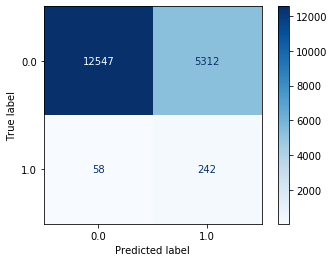

In [262]:
plot_confusion_matrix(final_logit, X_test_logit, y_test_logit, cmap=plt.cm.Blues)

In [263]:
print(classification_report(y_test_logit, logit_predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82     17859
         1.0       0.04      0.81      0.08       300

    accuracy                           0.70     18159
   macro avg       0.52      0.75      0.45     18159
weighted avg       0.98      0.70      0.81     18159



# Random Forest Model

In [264]:
rf_df = bank_df_impute.copy(deep=True)

In [265]:
for col in cat_cols:
    rf_df[col] = rf_df[col].astype('category')

In [266]:
y = rf_df['Approved']
X = rf_df.drop(['Approved'], axis=1)

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [268]:
for estimator in range(50,850,50):
    rf_model = RandomForestClassifier(n_estimators=estimator, random_state=204)
    print("Estimator " + str(estimator)+ ": " + 
          str(np.mean(cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1))))

Estimator 50: 0.7564385933292312
Estimator 100: 0.7814830332202025
Estimator 150: 0.7940492225015959
Estimator 200: 0.8011966685263994
Estimator 250: 0.8053398136639682
Estimator 300: 0.8076127703914471
Estimator 350: 0.810757789494085
Estimator 400: 0.8126046010633926
Estimator 450: 0.8141719029372911
Estimator 500: 0.8160312542504642
Estimator 550: 0.816780980039244
Estimator 600: 0.81759699534751
Estimator 650: 0.8177605070915381
Estimator 700: 0.8183428920638083
Estimator 750: 0.8186101919369293
Estimator 800: 0.8186647341599784


In [269]:
rf_model_1 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=204)
best_rfm_1 = GridSearchCV(rf_model_1, param_grid={'class_weight':['balanced',{0:2},{1:10}], 'max_depth':[None,3,4,6,10], 
                                                  'max_features':['sqrt','log2',None]},
                        cv=kfold, scoring='roc_auc', n_jobs=-1)

In [270]:
best_rfm_1.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=500, oob_score=True,
                                              random_state=204),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 2}, {1: 10}],
                         'max_depth': [None, 3, 4, 6, 10],
                         'max_features': ['sqrt', 'log2', None]},
             scoring='roc_auc')

In [271]:
best_rfm_1.best_params_

{'class_weight': {1: 10}, 'max_depth': 10, 'max_features': 'sqrt'}

In [272]:
np.mean(cross_val_score(best_rfm_1.best_estimator_, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8361742329688754

In [273]:
rf_model_2 = RandomForestClassifier(n_estimators=500, oob_score=True, class_weight={1:10},
                                    max_depth=10, max_features='sqrt', random_state=204)
best_rfm_2 = GridSearchCV(rf_model_2, param_grid={'min_samples_leaf':[1,2,3,6,10], 'min_samples_split':[2,3,10,100,200]},
                        cv=kfold, scoring='roc_auc', n_jobs=-1)

In [274]:
best_rfm_2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=RandomForestClassifier(class_weight={1: 10},
                                              max_depth=10, max_features='sqrt',
                                              n_estimators=500, oob_score=True,
                                              random_state=204),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3, 6, 10],
                         'min_samples_split': [2, 3, 10, 100, 200]},
             scoring='roc_auc')

In [275]:
best_rfm_2.best_params_

{'min_samples_leaf': 6, 'min_samples_split': 2}

In [276]:
np.mean(cross_val_score(best_rfm_2.best_estimator_, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8366638532802806

In [282]:
final_rf_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', max_depth=10, max_features='sqrt', 
                                        min_samples_leaf=6, min_samples_split=2, oob_score=True, random_state=204)

In [278]:
np.mean(cross_val_score(final_rf_model, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8366638532802806

In [283]:
final_rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=6,
                       n_estimators=500, oob_score=True, random_state=204)

In [284]:
rf_predictions = final_rf_model.predict(X_test)

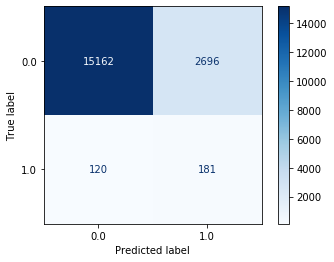

In [285]:
plot_confusion_matrix(final_rf_model, X_test, y_test, cmap=plt.cm.Blues)

In [286]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92     17858
         1.0       0.06      0.60      0.11       301

    accuracy                           0.84     18159
   macro avg       0.53      0.73      0.51     18159
weighted avg       0.98      0.84      0.90     18159



# Xtreme Gradient Boosting Model

In [287]:
xgb_df = bank_df_impute.copy(deep=True)

In [288]:
for col in cat_cols:
    xgb_df[col] = xgb_df[col].astype(int).astype('category')

In [289]:
y_xgb = xgb_df['Approved']
X_xgb = xgb_df.drop(['Approved'], axis=1)

In [290]:
X_xgb = pd.get_dummies(X_xgb)

In [291]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.3)

In [292]:
weight_1 = len([val for val in y_train_xgb if val==0])/len([val for val in y_train_xgb if val==1])
xgb_model = XGBClassifier(random_state=402)
best_xgb_model = GridSearchCV(xgb_model, param_grid={'scale_pos_weight':[weight_1,1,10,100], 'n_estimators':[750,1000,1500,2000], 
                                                     'learning_rate':[0.001,0.01,0.1]},
                             scoring=kappa, cv=kfold, n_jobs=-1)

In [360]:
best_xgb_model.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=402,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                            

In [361]:
best_xgb_model.best_params_

{'learning_rate': 0.01, 'n_estimators': 750, 'scale_pos_weight': 10}

In [363]:
np.mean(cross_val_score(best_xgb_model.best_estimator_, X_train_xgb, y_train_xgb, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8365748753933175

In [364]:
xgb_model_1 = XGBClassifier(n_estimators=750, learning_rate=0.01, scale_pos_weight=10, random_state=402)
best_xgb_model_1 = GridSearchCV(xgb_model_1, param_grid={'max_depth':[3,6,8,10], 'min_child_weight':[1,3,6,10]},
                             scoring=kappa, cv=kfold, n_jobs=-1)

In [365]:
best_xgb_model_1.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=750, n_jobs=None,
                                     num_parallel_tree=None, random_state=402,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=10, subsample=None,

In [366]:
best_xgb_model_1.best_params_

{'max_depth': 6, 'min_child_weight': 1}

In [367]:
np.mean(cross_val_score(best_xgb_model_1.best_estimator_, X_train_xgb, y_train_xgb, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8365748753933175

In [368]:
xgb_model_2 = XGBClassifier(n_estimators=750, learning_rate=0.01, scale_pos_weight=10, max_depth=6, min_child_weight=1, 
                            subsample=0.8, colsample_bytree=0.6, random_state=402)
best_xgb_model_2 = GridSearchCV(xgb_model_2, param_grid={'gamma':[0,0.1,0.5,1,10,50]},
                             scoring=kappa, cv=kfold, n_jobs=-1)

In [369]:
best_xgb_model_2.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=6, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=750, n_jobs=None,
                                     num_parallel_tree=None, random_state=402,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=10, subsample=0.8,
       

In [106]:
best_xgb_model_2.best_params_

{'gamma': 0.5}

In [370]:
np.mean(cross_val_score(best_xgb_model_2.best_estimator_, X_train_xgb, y_train_xgb, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.844190513020871

In [371]:
xgb_model_3 = XGBClassifier(n_estimators=750, learning_rate=0.01, scale_pos_weight=10, max_depth=6, min_child_weight=1, 
                            subsample=0.8, colsample_bytree=0.6, gamma=0.5, random_state=402)
best_xgb_model_3 = GridSearchCV(xgb_model_3, param_grid={'reg_alpha':[1e-10, 1e-5, 1e-2, 0.1, 1, 10, 100],
                                                         'reg_lambda':[1e-10, 1e-5, 1e-2, 0.1, 1, 10, 100]},
                             scoring=kappa, cv=kfold, n_jobs=-1)

In [372]:
best_xgb_model_3.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=204, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0.5,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=6, min_child_weight=1,
                                     missing=nan, m...traints=None,
                                     n_estimators=750, n_jobs=None,
                                     num_parallel_tree=None, random_state=402,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=10, subsample=0.8,
                 

In [373]:
best_xgb_model_3.best_params_

{'reg_alpha': 10, 'reg_lambda': 1}

In [374]:
np.mean(cross_val_score(best_xgb_model_3.best_estimator_, X_train_xgb, y_train_xgb, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8415470584690004

In [293]:
final_xgb_model = XGBClassifier(n_estimators=750, learning_rate=0.01, scale_pos_weight=weight_1, max_depth=6, min_child_weight=1, 
                            subsample=0.8, colsample_bytree=0.6, gamma=0.5, reg_alpha=10, reg_lambda=1, random_state=402)

In [294]:
np.mean(cross_val_score(final_xgb_model, X_train_xgb, y_train_xgb, cv=kfold, scoring='roc_auc', n_jobs=-1))

0.8322905304625158

In [295]:
final_xgb_model.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=0, num_parallel_tree=1, random_state=402,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=60.40724637681159,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [296]:
xgb_predictions = final_xgb_model.predict(X_test_xgb)

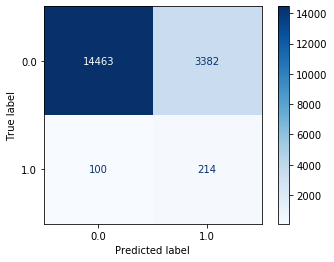

In [404]:
plot_confusion_matrix(final_xgb_model, X_test_xgb, y_test_xgb, cmap=plt.cm.Blues)

In [405]:
print(classification_report(y_test_xgb, xgb_predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     17845
         1.0       0.06      0.68      0.11       314

    accuracy                           0.81     18159
   macro avg       0.53      0.75      0.50     18159
weighted avg       0.98      0.81      0.88     18159

